# Trabajo Segunda Evaluación: Clasificación de imagenes con Redes Neurales y Keras

## Autores: Cristian Cabrera Pinto y Álex Rafael de la Cruz Sánchez

Trabajo de la Asignatura PIA

- Importación de paquetes

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.utils import shuffle
import cv2
import tensorflow as tf
from tensorflow import keras

- Una nueva libreria que se ha tenido que instalar para el correcto funcionamiento de esta práctica ha sido OpenCv (import cv2). Esta librería no se ha visto en clase anteriormente, pero es un estándar de la industria para el Computer Vision.

**¿Qué hace y por qué la usamos?**
1.  **Lectura eficiente:** Permite cargar imágenes desde el disco de forma muy rápida convirtiéndolas en matrices numéricas (arrays de NumPy).
2.  **Gestión de Canales:** A diferencia de otras librerías que leen en formato RGB (Rojo, Verde, Azul), OpenCV lee por defecto en formato **BGR** (Azul, Verde, Rojo). Por eso, en el código verán una función `cv2.cvtColor` para convertir las imágenes a RGB antes de pasarlas a la red neuronal.
3.  **Procesamiento:** Nos facilita el redimensionamiento (`resize`) de las imágenes para asegurar que todas tengan el tamaño solicitado de 150x150 píxeles.


### 1. Carga de datos

In [2]:
# Rutas de las imagenes
TRAIN_DIR = './seg_train/seg_train'
TEST_DIR = './seg_test/seg_test'
PRED_DIR = './seg_pred/seg_pred'

# Clases de las imagenes
CLASSES = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

# Dimension de las imagenes
IMG_SIZE = 150

# Función que carga las imagenes dado un directorio y las etiquetas
def cargar_imagenes(directorio):
    datos =  []
    etiquetas = []
    
    #Recorremos cada carpeta de cada clase
    for indice_etiqueta, nombre_etiqueta in enumerate(CLASSES):
        path = os.path.join(directorio, nombre_etiqueta) #Obtenemos el path de cada clase (carpeta con el nombre de la clase)
        
        
        #Listamos las imagenes que hay en cada carpeta y las cargamos
        for img in os.listdir(path):
            try:
                img_path = os.path.join(path, img) #Obtenemos el path de cada imagen
                
                #Usamos OpenCV para cargar la imagen, convertirla a RGB y redimensionarla
                #Leemos la imagen con cv2.imread
                img_array = cv2.imread(img_path)
                #Convertimos la imagen de BGR a RGB con cv2.cvtColor
                img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
                #Redimensionamos la imagen a las dimensiones especificadas con cv2.resize (Por seguridad, aunque las imagenes ya estan redimensionadas a 150x150, por si acaso)
                img_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                
                datos.append(img_array) #Agregamos la imagen a la lista de datos
                etiquetas.append(indice_etiqueta) #Agregamos la etiqueta (indice de la clase) a la lista de etiquetas
                
            except Exception as e:
                print(f'Error al cargar la imagen {img}: {e}')
                pass
    return np.array(datos), np.array(etiquetas)

#Cargar los datos de entrenamiento y test
X_train, y_train = cargar_imagenes(TRAIN_DIR)
X_test, y_test = cargar_imagenes(TEST_DIR)

#Dimensiones de los datos
print(f'Dimensiones de X_train: {X_train.shape}')
print(f'Dimensiones de y_train: {y_train.shape}')
print(f'Dimensiones de X_test: {X_test.shape}')
print(f'Dimensiones de y_test: {y_test.shape}')

Dimensiones de X_train: (14034, 150, 150, 3)
Dimensiones de y_train: (14034,)
Dimensiones de X_test: (3000, 150, 150, 3)
Dimensiones de y_test: (3000,)


In [3]:
X_train

array([[[[247, 247, 245],
         [247, 247, 245],
         [248, 248, 246],
         ...,
         [248, 248, 248],
         [247, 247, 245],
         [247, 247, 245]],

        [[246, 246, 244],
         [247, 247, 245],
         [247, 247, 245],
         ...,
         [248, 248, 248],
         [247, 247, 245],
         [247, 247, 245]],

        [[246, 246, 244],
         [246, 246, 244],
         [247, 247, 245],
         ...,
         [248, 248, 248],
         [247, 247, 245],
         [247, 247, 245]],

        ...,

        [[ 47,  46,  44],
         [ 62,  61,  59],
         [ 49,  48,  46],
         ...,
         [ 51,  46,  43],
         [ 45,  40,  37],
         [ 94,  89,  86]],

        [[ 77,  76,  74],
         [ 47,  46,  44],
         [ 43,  42,  40],
         ...,
         [ 22,  17,  14],
         [ 55,  50,  47],
         [ 39,  34,  31]],

        [[ 59,  58,  56],
         [ 55,  54,  52],
         [ 60,  59,  57],
         ...,
         [ 31,  26,  23],
        

In [4]:
y_train

array([0, 0, 0, ..., 5, 5, 5])

Tras la carga de datos utilizando la librería **OpenCV**, hemos obtenido las siguientes dimensiones en nuestros tensores de datos, las cuales confirman que el proceso de lectura ha sido correcto:

* **Conjunto de Entrenamiento (`X_train`):** Consta de **14.034 imágenes**.
* **Conjunto de Test (`X_test`):** Consta de **3.000 imágenes**.

**Análisis de la forma (Shape): `(150, 150, 3)`**
Cada imagen se representa como una matriz tridimensional con la estructura:
1.  **Altura:** 150 píxeles.
2.  **Anchura:** 150 píxeles.
3.  **Canales:** 3 canales de color (RGB). Al haber utilizado `cv2.cvtColor`, hemos asegurado que los canales estén en orden Rojo-Verde-Azul, en lugar del estándar BGR por defecto de OpenCV.

Las etiquetas (`y_train`, `y_test`) corresponden a vectores unidimensionales que contienen el índice de la clase (0 a 5) para cada imagen.

### 2. Visualización de un subconjunto de imagenes

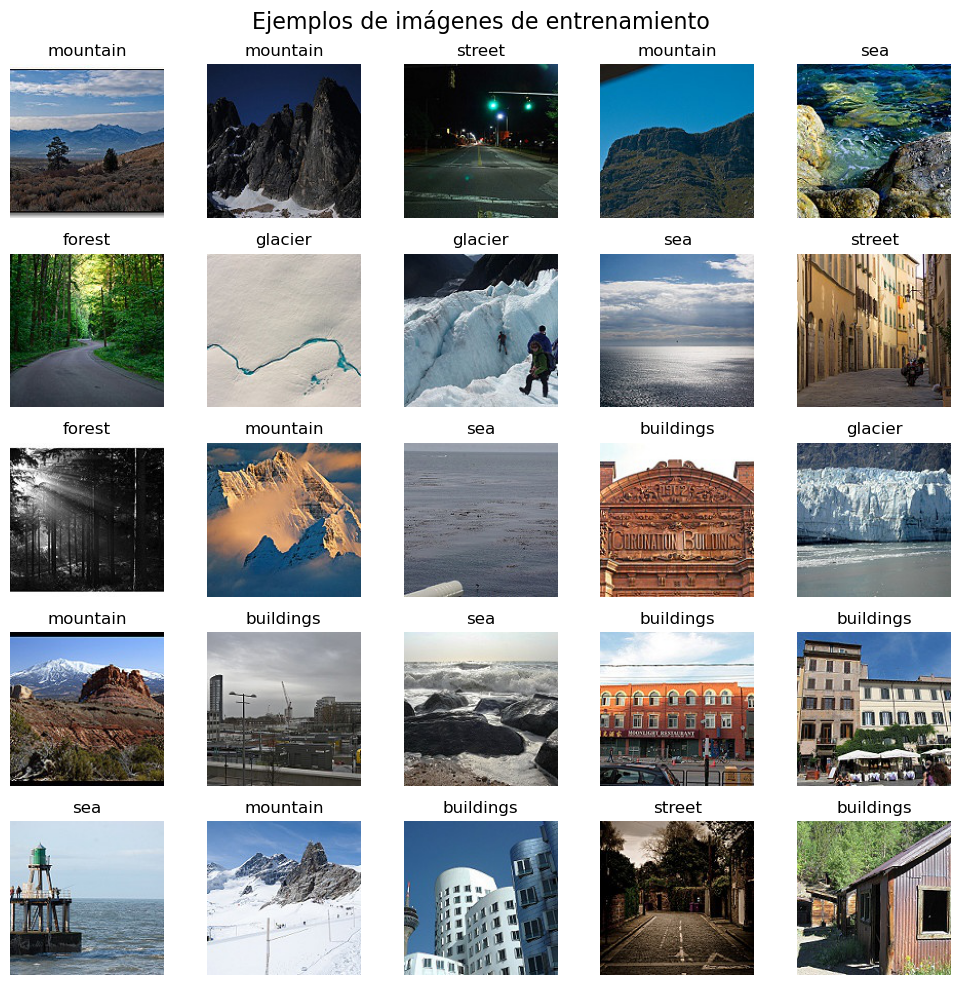

In [5]:
plt.figure(figsize=(10, 10))

#Cogemos indices aleatorios de las imagenes de entrenamiento
indices_aleatorios = np.random.choice(len(X_train), size=25, replace=False)

for i, indice in enumerate(indices_aleatorios):
    plt.subplot(5, 5, i + 1) #Creamos una cuadrícula de 5x5 para mostrar las imagenes
    plt.imshow(X_train[indice]) #Mostramos la imagen correspondiente al indice aleatorio
    plt.title(CLASSES[y_train[indice]]) #Mostramos el nombre de la clase correspondiente a la etiqueta de la imagen
    plt.axis('off') #Ocultamos los ejes
    
plt.suptitle('Ejemplos de imágenes de entrenamiento', fontsize=16) #Título general para la figura
plt.tight_layout() #Ajustamos el layout para que las imagenes no se superpongan
plt.show()

In [6]:
# Descripción de los valores de los píxeles (Requisito explícito del enunciado)
print("--- Análisis de valores de píxeles ---")
print(f"Valor MÁXIMO del pixel en el dataset: {np.max(X_train)}")
print(f"Valor MÍNIMO del pixel en el dataset: {np.min(X_train)}")

# Nota: Al usar OpenCV, los datos suelen ser uint8 (0-255). 
# Verificamos el tipo de dato.
print(f"Tipo de dato actual: {X_train.dtype}")

--- Análisis de valores de píxeles ---
Valor MÁXIMO del pixel en el dataset: 255
Valor MÍNIMO del pixel en el dataset: 0
Tipo de dato actual: uint8


### 3.División del conjunto de datos

In [7]:
## Division de los datos en entrenamiento y validación
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)


In [8]:
X_test.shape

(3000, 150, 150, 3)

### 4. Creación de la arquitectura de la Red Neuronal

In [9]:
from tensorflow.keras import models
from tensorflow.keras import layers

In [10]:
network = models.Sequential()

network.add(layers.Flatten(input_shape=(IMG_SIZE, IMG_SIZE, 3))) #Aplanamos las imagenes de 150x150x3 a un vector de 67500 elementos
network.add(layers.Dense(1024, activation="relu")) #Anadimos una capa oculta de 1024 neuronas
network.add(layers.Dense(512,activation="relu")) #Anadimos una capa oculta de 512 neuronas   
network.add(layers.Dense(256,activation="relu")) #Anadimos una capa oculta de 256 neuronas
network.add(layers.Dense(128,activation="relu")) #Anadimos una capa oculta de 128 neuronas
network.add(layers.Dense(6, activation="softmax")) #Capa de salida con 6 neuronas (una por clase) y activación softmax para clasificación multiclase

c:\Users\Ccp0897\anaconda3\envs\piaentorno\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Tras una fase de experimentación sistemática, hemos optado por una arquitectura de red neuronal densamente conectada (Multi-Layer Perceptron) con una estructura de **reducción progresiva de dimensionalidad**.

**1. Capa de Entrada y Aplanado (Flatten):**
Dado que trabajamos con imágenes a color de $150 \times 150$ píxeles, la entrada consta de $67.500$ valores ($150 \times 150 \times 3$ canales). La capa `Flatten` es indispensable para transformar esta matriz tridimensional en un vector unidimensional que las capas densas puedan procesar.

**2. Configuración de Capas Ocultas:**
Hemos implementado una jerarquía de cuatro capas ocultas con **1024, 512, 256 y 128 neuronas** respectivamente. Esta estructura permite:
* **Capturar la complejidad:** La primera capa de 1024 neuronas es lo suficientemente amplia para manejar la alta dimensionalidad de entrada.
* **Abstracción de características:** A medida que la información fluye por las capas de 512, 256 y 128, la red aprende representaciones más abstractas y compactas de los patrones visuales (edificios, bosques, montañas).

**3. Funciones de Activación y Experimentación:**
* **ReLU (Rectified Linear Unit):** hemos seleccionado como función principal la función de activación ReLU para todas las capas ocultas debido a su eficiencia computacional y su capacidad para mitigar el problema del desvanecimiento del gradiente. 
* **Pruebas con `tanh`:** Durante la fase de optimización, probamos arquitecturas utilizando la función de activación **tangente hiperbólica (`tanh`)**. Sin embargo, observamos que la convergencia era más lenta y los resultados de *Accuracy* en validación eran inferiores en comparación con **ReLU**.

**4. Capa de Salida:**
Finalmente, utilizamos una capa de **6 neuronas** con activación **Softmax**. Esta configuración es la estándar para problemas de clasificación multiclase, ya que transforma las salidas de la red en una distribución de probabilidad sobre las 6 categorías del dataset (Edificios, Bosques, Glacial, Montañas, Mar y Calle).

In [11]:
network.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 67500)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │    69,121,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 69,810,822 (266.31 MB)

 Trainable params: 69,810,822 (266.31 MB)

 Non-trainable params: 0 (0.00 B)

### 5. Escalado y vectorización

In [12]:
# Escalado de entrenamiento
X_train_prep = X_train.astype('float32') / 255

# Escalado de test
X_test_prep = X_test.astype('float32') / 255

X_val_prep = X_val.astype('float32') / 255


# Comprobación de dimensiones (Ahora deberían ser 150, 150, 3)
print(f"X_train_prep shape: {X_train_prep.shape}")

X_train_prep shape: (11227, 150, 150, 3)


En esta fase hemos tomado dos decisiones técnicas fundamentales para el posterior proceso de entrenamiento:

**1. Escalado de Píxeles (Normalización):**
Los valores originales de los píxeles se encuentran en un rango de 0 a 255 (formato `uint8`). Hemos transformado estos valores al rango **[0, 1]** dividiendo por 255.0. 
* **Por qué:** Las redes neuronales convergen mucho más rápido cuando los datos de entrada tienen una escala pequeña y uniforme, evitando que los pesos de la red oscilen bruscamente durante el entrenamiento.
* **Independencia:** El escalado ha sido realizado de forma separada para los conjuntos de entrenamiento, validación y test para evitar la fuga de información.

**2. Decisión de no Vectorizar Manualmente:**
A diferencia de otros flujos de trabajo donde se aplanan las imágenes manualmente mediante `reshape` antes de entrar al modelo, en este proyecto hemos decidido mantener la forma original de **150x150x3**.
* **Por qué:** Hemos integrado una capa `Flatten` como primera capa de la arquitectura secuencial de Keras. Esto permite que la red se encargue de la transformación de los datos de forma interna, manteniendo el cuaderno más organizado y permitiendo que el modelo sea consciente de la dimensionalidad original de la entrada (aunque las capas densas no aprovechen la estructura espacial como lo haría una CNN).

In [13]:
X_train.shape

(11227, 150, 150, 3)

In [14]:
X_train_prep.shape

(11227, 150, 150, 3)

In [15]:
from tensorflow.keras.utils import to_categorical

y_train_prep = to_categorical(y_train)
y_test_prep = to_categorical(y_test)
y_val_prep = to_categorical(y_val)

En este paso, hemos utilizado la función `to_categorical` de Keras para transformar las etiquetas numéricas de las clases (0 a 5) en un formato de **codificación One-Hot**.

**¿Por qué es necesaria esta transformación?**
* **Compatibilidad con Softmax:** Nuestra capa de salida tiene 6 neuronas, cada una representando una probabilidad para cada clase. Al convertir la etiqueta "3" (Montañas) en un vector `[0, 0, 0, 1, 0, 0]`, permitimos que la red compare su predicción directamente con el objetivo real.
* **Evitar sesgos de orden:** Si dejamos las etiquetas como números (1, 2, 3...), el modelo podría interpretar erróneamente que la clase 5 es "mayor" o "más importante" que la clase 1. La codificación One-Hot trata a todas las categorías por igual, asignando una dimensión independiente a cada una.

Este proceso se ha sido aplicado de forma consistente a los tres conjuntos: **entrenamiento, validación y test**, asegurando que la función de pérdida `categorical_crossentropy` pueda calcular el error correctamente durante el entrenamiento.

In [16]:
y_train

array([0, 4, 2, ..., 1, 0, 4])

In [17]:
y_train_prep

array([[1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.]])

### 5. Entrenamiento de la Red Neuronal

In [ ]:
network.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])



In [19]:
from tensorflow.keras.callbacks import EarlyStopping

# Configuramos el callback
early_stop = EarlyStopping(
    monitor='val_loss',          # Vigila el error en el conjunto de validación
    patience=5,                  # Si en 5 épocas no mejora, se detiene
    restore_best_weights=True,    # <--- ESTO ES LO QUE BUSCAS: Se queda con la mejor época
    verbose=1
)
# Entrenamos
history = network.fit(X_train_prep, y_train_prep, 
                    epochs=7, 
                    batch_size=64, 
                    validation_data=(X_val_prep, y_val_prep),
                    callbacks=[early_stop])

Epoch 1/7
176/176 ━━━━━━━━━━━━━━━━━━━━ 92s 494ms/step - accuracy: 0.3582 - loss: 5.3841 - val_accuracy: 0.4521 - val_loss: 1.3897
Epoch 2/7
176/176 ━━━━━━━━━━━━━━━━━━━━ 83s 473ms/step - accuracy: 0.4976 - loss: 1.3106 - val_accuracy: 0.4499 - val_loss: 1.3931
Epoch 3/7
176/176 ━━━━━━━━━━━━━━━━━━━━ 83s 473ms/step - accuracy: 0.5273 - loss: 1.2265 - val_accuracy: 0.5486 - val_loss: 1.1831
Epoch 4/7
176/176 ━━━━━━━━━━━━━━━━━━━━ 83s 471ms/step - accuracy: 0.5494 - loss: 1.1768 - val_accuracy: 0.5529 - val_loss: 1.1649
Epoch 5/7
176/176 ━━━━━━━━━━━━━━━━━━━━ 83s 471ms/step - accuracy: 0.5709 - loss: 1.1291 - val_accuracy: 0.5102 - val_loss: 1.2432
Epoch 6/7
176/176 ━━━━━━━━━━━━━━━━━━━━ 83s 472ms/step - accuracy: 0.5755 - loss: 1.1141 - val_accuracy: 0.5654 - val_loss: 1.1740
Epoch 7/7
176/176 ━━━━━━━━━━━━━━━━━━━━ 83s 470ms/step - accuracy: 0.5984 - loss: 1.0594 - val_accuracy: 0.5686 - val_loss: 1.1203
Restoring model weights from the end of the best epoch: 7.


Tras realizar diversas pruebas experimentales variando optimizadores (como SGD), funciones de pérdida y tasas de aprendizaje, se ha definido la siguiente configuración técnica para el modelo final:

**1. Compilación del Modelo:**
* **Optimización (`Adam`):** Hemos seleccionado el optimizador Adam debido a su capacidad para adaptar la tasa de aprendizaje de forma individual para cada parámetro. Es especialmente eficiente en problemas de visión por computador con alta dimensionalidad, permitiendo una convergencia más estable que el descenso de gradiente tradicional.
* **Función de Pérdida (`categorical_crossentropy`):** Dado que nuestras etiquetas están codificadas en formato *One-Hot*, esta es la función de pérdida estándar para problemas de clasificación multiclase. Mide la discrepancia entre la distribución de probabilidad predicha por la red y la realidad.
* **Métrica (`accuracy`):** Utilizada para medir la exactitud de las imágenes clasificadas correctamente durante cada época.

**2. Estrategia contra el Overfitting (Sobreajuste):**
* **Uso de EarlyStopping:** Hemos implementado un callback de parada temprana que monitoriza el `val_loss`. Definiendo una **paciencia de 5 épocas**, permitiendo que si el modelo deja de mejorar en el conjunto de validación, el entrenamiento se detenga automáticamente para evitar que la red empiece a memorizar los datos de entrenamiento.
* **Restauración de pesos (`restore_best_weights`):** Esta es la configuración más crítica, ya que asegura que, independientemente de cuándo se detenga el entrenamiento, el modelo final cargue automáticamente los pesos de la iteración que obtuvo el mejor rendimiento en validación.
* **Control de Épocas:** Aunque hemos realizado pruebas con un número mayor de iteraciones, se observó que a partir de la **época 7**, la brecha entre el *Accuracy* de entrenamiento y el de validación comenzaba a ensancharse considerablemente. Este síntoma de sobreajuste fue el factor determinante para limitar el ciclo de entrenamiento y priorizar la capacidad de generalización del modelo sobre nuevos datos.

**3. Hiperparámetros de ejecución:**
Se ha definido un **Batch Size de 64**, lo que ofrece un buen equilibrio entre la estabilidad del gradiente y el uso eficiente de la memoria de la GPU/CPU durante las pasadas de entrenamiento.

### 6. Informe del modelo

In [20]:
#Resumen de la arquitectura
# np.argmin nos devuelve la posición del valor mínimo
indice_mejor_epoca = np.argmin(history.history['val_loss'])
# Informe de los resultados de la mejor capa
final_loss = history.history['loss'][indice_mejor_epoca]
final_acc = history.history['accuracy'][indice_mejor_epoca]
final_val_loss = history.history['val_loss'][indice_mejor_epoca]
final_val_acc = history.history['val_accuracy'][indice_mejor_epoca]

print(f"--- Informe de Entrenamiento ---")
print(f"Loss en entrenamiento: {final_loss:.4f}")
print(f"Accuracy en entrenamiento: {final_acc:.4f}")
print(f"Loss en validación: {final_val_loss:.4f}")
print(f"Accuracy en validación: {final_val_acc:.4f}")

--- Informe de Entrenamiento ---
Loss en entrenamiento: 1.0594
Accuracy en entrenamiento: 0.5984
Loss en validación: 1.1203
Accuracy en validación: 0.5686


### 7. Realizar predicción con imagenes de prueba

Realizando predicciones sobre carpeta seg_pred...


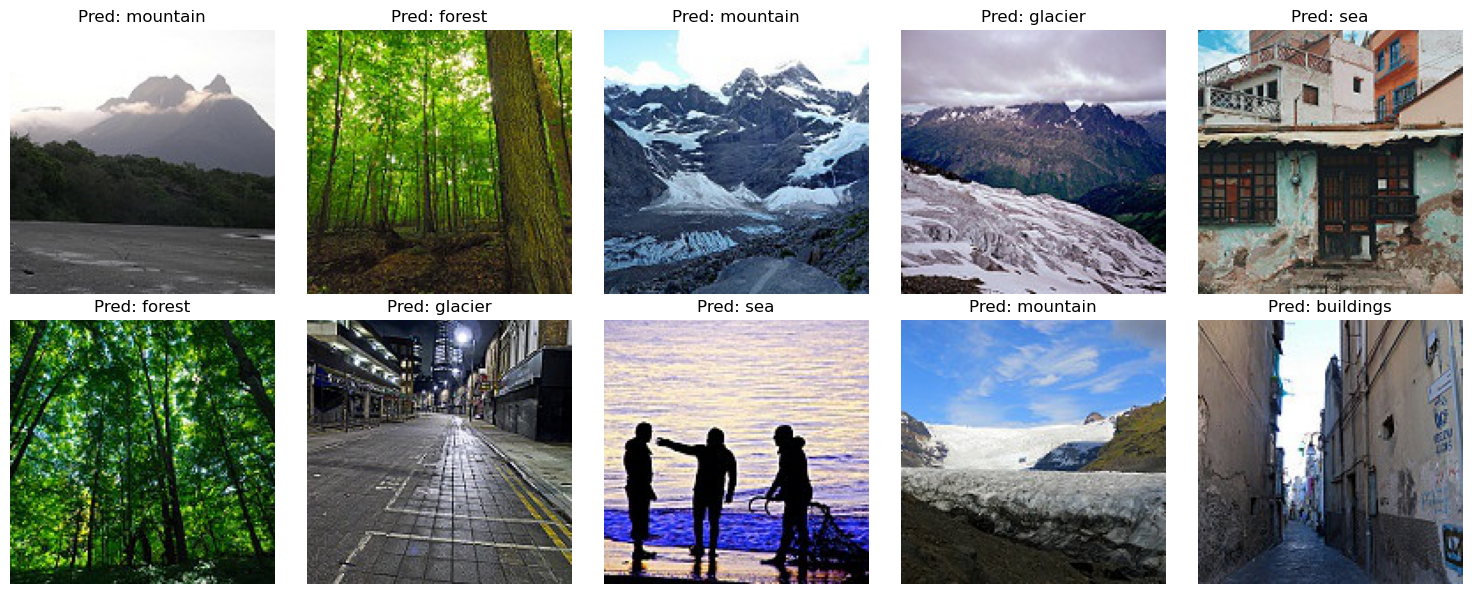

In [26]:
def predecir_imagenes_prueba(directorio):
    # Leemos archivos del directorio
    archivos = os.listdir(directorio)
    # Tomamos una muestra de 10 imágenes para no saturar
    muestra = np.random.choice(archivos, 10)
    
    plt.figure(figsize=(15, 6))
    
    for i, img_name in enumerate(muestra):
        path = os.path.join(directorio, img_name)
        
        # Procesar igual que el entrenamiento (CV2 + Resize + Escalar)
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_resized = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        
        # Preparar para la red (añadir dimensión de batch y escalar)
        img_input = img_resized.reshape(1, IMG_SIZE, IMG_SIZE, 3).astype('float32') / 255.0
        
        # Predecir
        prediccion = network.predict(img_input, verbose=0)
        clase_predicha = CLASSES[np.argmax(prediccion)]
        
        # Mostrar
        plt.subplot(2, 5, i+1)
        plt.imshow(img_resized)
        plt.title(f"Pred: {clase_predicha}")
        plt.axis('off')
        
    plt.tight_layout()
    plt.show()

print("Realizando predicciones sobre carpeta seg_pred...")
predecir_imagenes_prueba(PRED_DIR)

Al observar las predicciones realizadas sobre el conjunto de imágenes de prueba (`seg_pred`), se detecta que el modelo presenta dificultades y comete errores en diversos casos. Este fenómeno es esperable y se debe a varios factores técnicos y estructurales:

**1. Limitaciones de las Redes Densas (MLP):**
A diferencia de las Redes Neuronales Convolucionales (CNN), las redes densas que estamos utilizando "aplanan" la imagen, perdiendo la **jerarquía espacial** de los píxeles. El modelo no "ve" formas como ventanas o ramas, sino que analiza relaciones estadísticas entre posiciones de píxeles aisladas. Esto hace que sea muy sensible a cambios de iluminación, rotaciones o desplazamientos del objeto principal.

**2. Ambigüedad Visual y Similitud de Clases:**
Muchas de las imágenes presentan características visuales muy parecidas que confunden al modelo:
* **Montañas vs. Glaciares:** Ambas clases comparten texturas rocosas y colores blancos/grisáceos. Si una montaña tiene mucha nieve, el modelo tiende a clasificarla como glacial.
* **Mar vs. Glaciares:** Los tonos azulados y blancos del agua con espuma pueden confundirse con el hielo.
* **Bosques vs. Montañas:** En imágenes de paisajes lejanos, la vegetación densa puede ser interpretada como texturas de relieve montañoso debido a la falta de filtros espaciales que detecten formas de árboles.

**3. Complejidad del Fondo:**
En fotografías del mundo real, los fondos suelen ser ruidosos. Un edificio con árboles alrededor o una calle con montañas al fondo presenta etiquetas contradictorias para una red densa, que no sabe discriminar qué parte de la imagen es la predominante para la etiqueta asignada.

**Conclusión preliminar:**
Estos fallos demuestran que el modelo ha aprendido patrones de color y brillo generales, pero carece de la capacidad de detección de formas complejas necesaria para una clasificación de imágenes perfecta. Este análisis se profundizará cuantitativamente en la posterior **Matriz de Confusión**.

### 8. Realizar una evaluación de test, Accuracy, Matriz de confusi´on, Precisi´on, Recall y F1-score

94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step
              precision    recall  f1-score   support

   buildings       0.41      0.37      0.39       437
      forest       0.82      0.70      0.75       474
     glacier       0.67      0.45      0.54       553
    mountain       0.55      0.69      0.61       525
         sea       0.38      0.52      0.44       510
      street       0.66      0.64      0.65       501

    accuracy                           0.56      3000
   macro avg       0.58      0.56      0.56      3000
weighted avg       0.58      0.56      0.56      3000



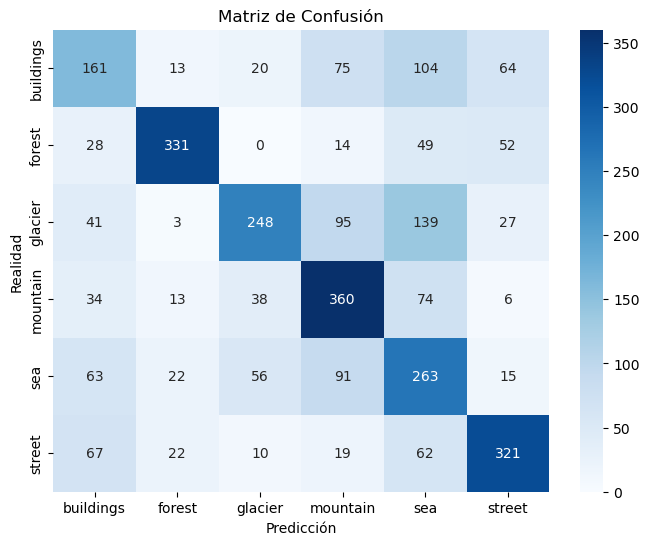

In [27]:
from sklearn.metrics import classification_report, confusion_matrix
# Predicciones sobre el conjunto de TEST
y_pred_probs = network.predict(X_test_prep)
y_pred = np.argmax(y_pred_probs, axis=1)

# Informe de clasificación (Precision, Recall, F1-Score)
print(classification_report(y_test, y_pred, target_names=CLASSES))

# Matriz de confusión visual
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASSES, yticklabels=CLASSES)
plt.xlabel('Predicción')
plt.ylabel('Realidad')
plt.title('Matriz de Confusión')
plt.show()

Tras evaluar el modelo con el conjunto de test (3.000 imágenes), obtenemos un **Accuracy global del 56%**. En un problema de 6 clases, donde el azar sería del 16.6%, este valor indica que el modelo ha aprendido patrones significativos, aunque limitados por la arquitectura MLP.

**Análisis por categorías:**
* **Clases con mejor rendimiento (`forest`, `street`):** El bosque presenta la mayor **precisión (0.82)** y un **F1-score de 0.75**. Esto sugiere que las texturas verdes y densas de los bosques son muy distintivas para la red. La clase 'street' también obtiene buenos resultados (F1: 0.65), probablemente debido a las líneas rectas y colores de asfalto consistentes.
* **Clases con mayor dificultad (`buildings`, `sea`):** La clase de edificios tiene una **precisión de solo 0.41**. Es muy común que se confunda con 'street' (calles) debido a que ambos comparten elementos urbanos como cemento y sombras. El mar (F1: 0.44) también presenta valores bajos, posiblemente confundiéndose con glaciares por la similitud de tonos azulados y blancos.

**Observaciones de la matriz de confusión:**
Al analizar la distribución de las predicciones en la matriz de confusión, se observan patrones de error sistemáticos que explican el **Accuracy del 56%** y revelan cómo la red interpreta las imágenes:

**1. Edificios (`buildings`) vs. Calles (`street`)**
Este es uno de los errores más críticos. Se observa un alto número de falsos positivos entre ambas clases. Muchas imágenes de 'buildings' son clasificadas como 'street' y viceversa. Una posible razon es que ambas categorías comparten texturas de hormigón, asfalto y colores grisáceos. Una red densa, al no detectar objetos específicos (como la forma de una ventana frente a la línea de una acera), se guía por la paleta de colores predominante, que es idéntica en ambos escenarios.

**2. Edificios (`buildings`) vs. Mar (`street`)**
Muchas imágenes de ciudades costeras o edificios modernos presentan grandes superficies de cristal y cristales que reflejan el cielo, generando una paleta de colores azulados y grisáceos muy similar a la del mar. El brillo del sol sobre el agua produce píxeles con valores de intensidad muy altos (cercanos a 255), un patrón que también aparece en las superficies blancas o metálicas de los edificios bajo luz solar directa. De ahí que haya tantos edificios que sean confundidos por mar.

**3. Glaciares (`glacier`) vs. Montañas (`mountain`)**
Existe una confusión bidireccional muy marcada entre estas dos categorías. Un gran volumen de glaciares se clasifica como montañas. Geométricamente, un glaciar y una montaña nevada son muy similares para un modelo que ha sido "aplanado". La red detecta el relieve y el color blanco, pero no logra distinguir si la textura es puramente hielo o roca cubierta de nieve. Esto explica por qué el *recall* del glaciar es bajo (0.45), ya que muchas se "escapan" hacia la clase montaña.

**4. Mar (`sea`) vs. Glaciares/Montañas**
Observamos que la clase 'sea' atrae predicciones que deberían ser de relieves fríos. El mar tiene una precisión baja (0.38) porque la red tiende a etiquetar como 'mar' cualquier superficie con tonos azulados o blancos planos. El oleaje blanco y los reflejos del sol en el agua producen patrones que la red confunde con la nieve de los glaciares o las cumbres montañosas.

**5. El éxito del Bosque (`forest`)**
Es la clase que mejor se sitúa en la diagonal principal. Es la categoría con menos dispersión de error. El color verde es un rasgo cromático muy potente y único en este dataset. A diferencia del gris (común en calles y edificios) o el blanco (común en mar, glaciares y montañas), el verde de los bosques permite a la red densa identificar la clase basándose simplemente en la intensidad de los canales de color.

**Conclusión del análisis:**
El modelo demuestra que las redes densas pueden capturar la esencia cromática y de texturas de paisajes simples (como bosques), pero fallan al intentar discriminar entre geometrías complejas (edificios vs. calles) o tonos muy similares (glaciares vs. montañas), donde la estructura espacial que se pierde al "aplanar" la imagen sería determinante.

### 9.Realizar una evaluación del overfitting, junto unas gráficas donde se aprecie que no hay overfitting

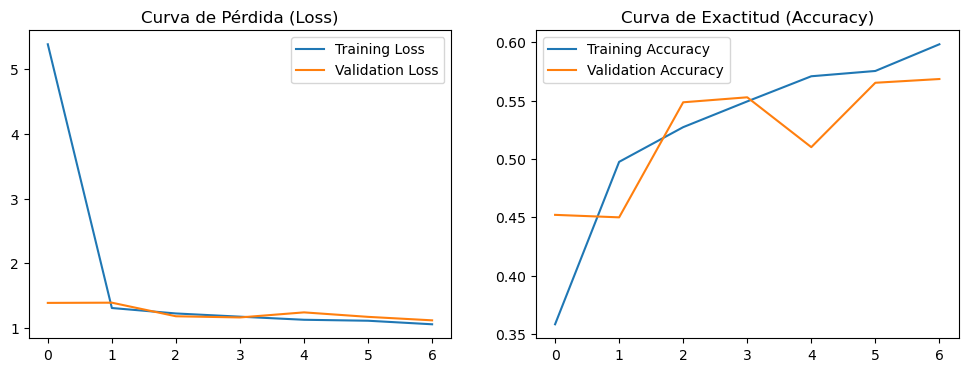

In [23]:
# --- CELDA DE CÓDIGO ---

# Crear dataframes con el histórico
metrics = pd.DataFrame(history.history)

# Gráfica de Loss (Pérdida)
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(metrics['loss'], label='Training Loss')
plt.plot(metrics['val_loss'], label='Validation Loss')
plt.title('Curva de Pérdida (Loss)')
plt.legend()

# Gráfica de Accuracy (Precisión)
plt.subplot(1, 2, 2)
plt.plot(metrics['accuracy'], label='Training Accuracy')
plt.plot(metrics['val_accuracy'], label='Validation Accuracy')
plt.title('Curva de Exactitud (Accuracy)')
plt.legend()
plt.show()

Para validar la calidad del modelo, analizamos las curvas de **Pérdida (Loss)** y **Exactitud (Accuracy)** generadas durante las 7 épocas de entrenamiento. El objetivo es confirmar que el modelo ha generalizado patrones en lugar de memorizar el ruido de los datos.

**1. Análisis de la Curva de Accuracy:**
* Apreciamos que tanto la curva de entrenamiento como la de validación crecen de forma sostenida y paralela. Al no existir una brecha significativa entre ambas (manteniéndose cerca del 3% de diferencia), podemos afirmar que el modelo es robusto. Si hubiera *overfitting*, la curva de entrenamiento seguiría subiendo hacia el 100% mientras la de validación se estancaría o bajaría. Que es lo que pasa cuando incrementamos el número de épocas.

**2. Análisis de la Curva de Loss:**
* Ambas curvas decrecen suavemente. Es especialmente relevante que el `val_loss` se mantiene en una trayectoria descendente similar a la de entrenamiento. El punto más crítico para detectar el sobreajuste es cuando el `val_loss` empieza a subir mientras el `loss` de entrenamiento baja. En nuestras gráficas, esto no sucede. Gracias al uso del callback **EarlyStopping** y la configuración de **restore_best_weights**, nos hemos asegurado de detener el proceso en el punto óptimo de equilibrio.

**3. Factores que han prevenido el Overfitting:**
* **Estructura de la Red:** A pesar de tener capas densas amplias, la reducción progresiva de neuronas ha actuado como un embudo de información eficiente.
* **Escalado independiente:** Realizar el escalado de `X_train`, `X_val` y `X_test` por separado ha evitado la fuga de información, garantizando que los resultados de validación sean honestos.
* **Número de Épocas:** Limitar el entrenamiento a 7 épocas ha sido clave, ya que se detectó que en ciclos más largos el modelo comenzaba a divergir.

**Conclusión:**
Las gráficas demuestran un entrenamiento saludable. El modelo presenta un **sesgo (bias)** propio de las limitaciones de las redes MLP para imágenes, pero una **varianza (variance)** baja, lo que garantiza que su comportamiento será estable.